# Wasserstein non-negative matrix factorisation

*You are seeing the
notebook output generated by
[Literate.jl](https://github.com/fredrikekre/Literate.jl) from the
[Julia source file](https://github.com/JuliaOptimalTransport/OptimalTransport.jl/blob/master/examples/nmf/script.jl).
The rendered HTML can be viewed [in the docs](https://juliaoptimaltransport.github.io/OptimalTransport.jl/dev/examples/nmf/).*

In this example, we implement Wasserstein non-negative matrix factorisation (W-NMF)
following the paper [^RCP16] by Rolet et al.

[^RCP16]: Rolet, Antoine, Marco Cuturi, and Gabriel Peyré. ["Fast dictionary learning with a smoothed Wasserstein loss."](https://marcocuturi.net/Papers/rolet16fast.pdf) Artificial Intelligence and Statistics. PMLR, 2016.

## Introduction

Matrix decomposition is a classical problem in machine learning. Given a $m \times n$ matrix $X$ representing $n$ repeated $m$-dimensional observations, one may seek matrices $D, \Lambda$ of appropriate dimensions such that
$$
X \approx D \Lambda.
$$
For a target rank $k < \min \{ m, n \}$, i.e. $D \in \mathbb{R}^{m \times k}, \Lambda \in \mathbb{R}^{k \times n}$, this problem can be thought of as seeking a low-dimensional linear representation $D \Lambda$ of the potentially high-dimensional dataset $X$.

Lee and Seung [^LS99] observed that the data matrix $X$ is non-negative in many practical applications, and that naturally one may want the factor matrices $D, \Lambda$ to be also non-negative.

[^LS99]: Lee, Daniel D., and H. Sebastian Seung. "Learning the parts of objects by non-negative matrix factorization." Nature 401.6755 (1999): 788-791.

For a given $m \times n$ matrix $X \ge 0$, finding the factor matrices $D \in \mathbb{R}^{m \times k}, \Lambda \in \mathbb{R}^{k \times n}$ such that $X \approx D \Lambda$ with $D \ge 0, \Lambda \ge 0$ is known as the rank-$k$ non-negative matrix factorization (NMF) problem. Typically, such an approximate representation is sought by solving a minimisation problem
$$
\min_{D \in \mathbb{R}^{m \times k}, \Lambda \in \mathbb{R}^{k \times n}, D \ge 0, \Lambda \ge 0} \Phi(X, D \Lambda),
$$
where $(X, Y) \mapsto \Psi(X, Y)$ is a loss function defined on matrices. Commonly used choices of $\Phi$ include the squared Frobenius loss $\Phi(X, Y) = \| X - Y \|_F^2$ and Kullback-Leibler divergence $\Phi(X, Y) = \sum_{ij} X_{ij} \log(X_{ij}/Y_{ij})$.

Both these loss functions (and many other common choices) decompose elementwise in their arguments, that is, they can be written as $\Phi(X, Y) = \sum_{ij} f(X_{ij}, Y_{ij})$ for some function $f$ acting on scalars.

Rolet et al. note that pointwise loss functions cannot account for spatial correlations in datasets with underlying geometry, and propose to use entropy-regularised optimal transport as a loss function that is sensitive to the spatial arrangement of the data.
They argue that for datasets such as images, optimal transport is a more natural choice of loss function, and that it achieves superior performance.

In particular, suppose that the columns of $X$ encode image data, and that $C \in \mathbb{R}^{m \times m}$ encodes the squared Euclidean distances on the imaging domain. The problem that Rolet et al. pose is
$$
\min_{D \in \mathbb{R}^{m \times k}_{\ge 0}, \Lambda \in \mathbb{R}^{k \times n}_{\ge 0}} \sum_{i = 1}^{n} \operatorname{OT}_{\varepsilon}(X_i, (D\Lambda)_i) + \rho_1 E(D) + \rho_2 E(\Lambda),
$$
where $\operatorname{OT}_{\varepsilon}(\alpha, \beta)$ is the entropy-regularised optimal transport loss between two probability distributions $\alpha, \beta$ for a cost $C$, and $E$ is an entropy barrier function (a smooth approximation to the non-negativity constraint),
$$
E(A) = \sum_{ij} (A_{ij} \log(A_{ij}) - 1).
$$
The parameters $\rho_1, \rho_2$ control how "sharp" the non-negativity constraints are. As $\rho_1, \rho_2 \to 0$, the smoothed constraint approaches the hard non-negativity constraint. Finally, $\varepsilon$ controls the regularisation level for the optimal transport loss.

This example shows how this method can be implemented using functions from the `Dual` submodule of OptimalTransport.jl.

## Set up prerequisites

Load packages that will be required later.

In [1]:
using OptimalTransport
import OptimalTransport.Dual: Dual
using MLDatasets: MLDatasets
using StatsBase
using Plots;
default(; palette=:Set1_3)
using LogExpFunctions
using NNlib: NNlib
using LinearAlgebra
using Distances
using Base.Iterators
using NMF
using Optim

Define `simplex_norm!`, which normalises `x` to sum to `1` along `dims`.

In [2]:
function simplex_norm!(x; dims=1)
    return x .= x ./ sum(x; dims=dims)
end

simplex_norm! (generic function with 1 method)

## Implementation

We now implement Wasserstein-NMF. Rolet et al. split the original non-convex problem into a pair of convex problems, one for $D$ and one for $\Lambda$.
$$
\begin{aligned}
&\min_{D \in \mathbb{R}^{m \times k}} \sum_{i = 1}^{n} \operatorname{OT}_{\varepsilon}(X_i, (D\Lambda)_i) + \rho_2 E(D), \\
&\min_{\Lambda \in \mathbb{R}^{k \times n}} \sum_{i = 1}^{n} \operatorname{OT}_{\varepsilon}(X_i, (D\Lambda)_i) + \rho_1 E(\Lambda).
\end{aligned}
$$
For each of these problems, the dual problem can be derived (see Section 3.3 of Rolet et al. for details on how this is done). These turn out to be
$$
\begin{aligned}
&\min_{G \in \mathbb{R}^{m \times n}} \sum_{i = 1}^n \operatorname{OT}_{\varepsilon}^*(X_i, G_i) + \rho_2 \sum_{i = 1}^{n} E^*(-(G \Lambda^\top)_i / \rho_2) \\
&\min_{G \in \mathbb{R}^{m \times n}} \sum_{i = 1}^n \operatorname{OT}_{\varepsilon}^*(X_i, G_i) + \rho_1 \sum_{i = 1}^{n} E^*(-(D^\top G)_i / \rho_1).
\end{aligned}
$$
The semi-dual of entropy-regularised optimal transport loss, $\operatorname{OT}_{\varepsilon}$, is implemented as `Dual.ot_entropic_semidual` and its gradient can be computed by `Dual.ot_entropic_semidual_grad`. $E^*$ turns out to be `logsumexp`, for which we implement a wrapper function:

In [3]:
function E_star(x; dims=1)
    return logsumexp(x; dims=dims)
end;

The gradient of `logsumexp` is `softmax`, so we define also its gradient:

In [4]:
function E_star_grad(x; dims=1)
    return NNlib.softmax(x; dims=1)
end;

Thus, for each problem we may define the dual objective and its gradient. We note that `ot_entropic_semidual(_grad)` automatically broadcasts along columns of its input. There is therefore no need to make multiple calls to the function, thus allowing for more efficient evaluation.

In [5]:
function dual_obj_weights(X, K, ε, D, G, ρ1)
    return sum(Dual.ot_entropic_semidual(X, G, ε, K)) + ρ1 * sum(E_star(-D' * G / ρ1))
end
function dual_obj_weights_grad!(∇, X, K, ε, D, G, ρ1)
    return ∇ .= Dual.ot_entropic_semidual_grad(X, G, ε, K) - D * E_star_grad(-D' * G / ρ1)
end
function dual_obj_dict(X, K, ε, Λ, G, ρ2)
    return sum(Dual.ot_entropic_semidual(X, G, ε, K)) + ρ2 * sum(E_star(-G * Λ' / ρ2))
end
function dual_obj_dict_grad!(∇, X, K, ε, Λ, G, ρ2)
    return ∇ .= Dual.ot_entropic_semidual_grad(X, G, ε, K) - E_star_grad(-G * Λ' / ρ2) * Λ
end;

The only remaining part of Wasserstein-NMF to implement is the conversion at optimality from the dual variable $G$ to the primal variables $D, \Lambda$. From the results of Theorems 3 and 4 in Rolet et al., we have for $\Lambda$:
$$
\Lambda_i = \operatorname{softmax}((-D^\top G)_i / \rho_1),
$$
and we have for $D$:
$$
D_i = \operatorname{softmax}((-G \Lambda^\top)_i / \rho_2).
$$

In [6]:
function getprimal_weights(D, G, ρ1)
    return NNlib.softmax(-D' * G / ρ1; dims=1)
end
function getprimal_dict(Λ, G, ρ2)
    return NNlib.softmax(-G * Λ' / ρ2; dims=1)
end;

We can now implement functions `solve_weights` and `solve_dict` that solve the respective dual problems for the next iterates of `Λ` and `D`.

In [7]:
function solve_weights(X, K, ε, D, ρ1; alg, options)
    opt = optimize(
        g -> dual_obj_weights(X, K, ε, D, g, ρ1),
        (∇, g) -> dual_obj_weights_grad!(∇, X, K, ε, D, g, ρ1),
        zero.(X),
        alg,
        options,
    )
    return getprimal_weights(D, Optim.minimizer(opt), ρ1)
end
function solve_dict(X, K, ε, Λ, ρ2; alg, options)
    opt = optimize(
        g -> dual_obj_dict(X, K, ε, Λ, g, ρ2),
        (∇, g) -> dual_obj_dict_grad!(∇, X, K, ε, Λ, g, ρ2),
        zero.(X),
        alg,
        options,
    )
    return getprimal_dict(Λ, Optim.minimizer(opt), ρ2)
end;

## Example: noisy univariate Gaussians

We set up each observation as a mixture of 3 Gaussians with means sampled from `N(6, σ), N(0, σ), N(-6, σ)` respectively, and mixture weights sampled uniformly from `[0, 1]`. The resulting mixture model is normalised to sum to 1 on the discrete domain `coord`.

In [8]:
f(x, μ, σ) = exp.(-(x .- μ) .^ 2)
coord = range(-12, 12; length=100)
N = 100
σ = 1
X = hcat(
    [
        rand() * f(coord, σ * randn() + 6, 1) +
        rand() * f(coord, σ * randn(), 1) +
        rand() * f(coord, σ * randn() - 6, 1) for _ in 1:N
    ]...,
)
X = simplex_norm!(X);

We visualise the  observations.

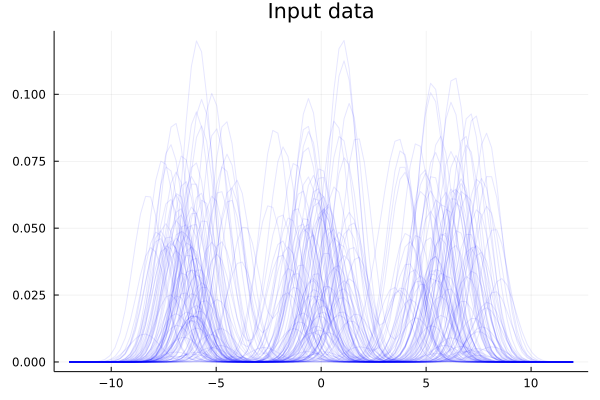

In [9]:
plot(coord, X; alpha=0.1, color=:blue, title="Input data", legend=nothing)

We can apply NMF with a squared Frobenius loss using the NMF.jl package. We seek `k = 3` components.  This performs poorly, since the pointwise nature of the loss function cannot handle the translational noise in the data.

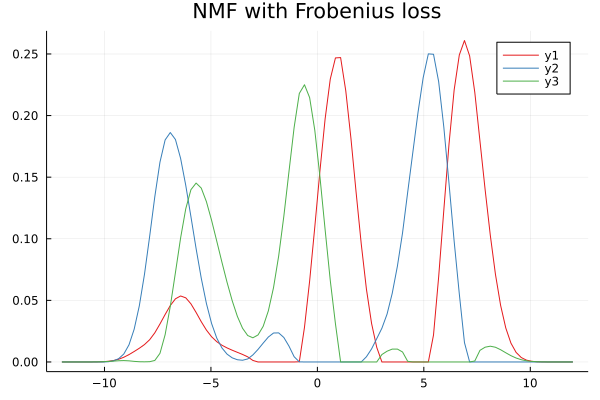

In [10]:
k = 3
result = nnmf(X, k; alg=:multmse)
plot(coord, result.W; title="NMF with Frobenius loss", palette=:Set1_3)

We can now set up a cost matrix corresponding to the domain `coord`.

In [11]:
C = pairwise(SqEuclidean(), coord)
C = C / mean(C);

Specify parameters

In [12]:
ε = 0.025
ρ1, ρ2 = (5e-2, 5e-2);

Compute Gibbs kernel

In [13]:
K = exp.(-C / ε);

Now we use a random initialisation, where columns of `D` and `Λ` are normalised to sum to 1.

In [14]:
D = rand(size(X, 1), k) # dictionary
simplex_norm!(D; dims=1) # norm columnwise
Λ = rand(k, size(X, 2)) # weights
simplex_norm!(Λ; dims=1); # norm rowwise

We now run 10 iterations of Wasserstein-NMF.

In [15]:
n_iter = 10
for iter in 1:n_iter
    @info "Wasserstein-NMF: iteration $iter"
    D .= solve_dict(
        X,
        K,
        ε,
        Λ,
        ρ2;
        alg=LBFGS(),
        options=Optim.Options(;
            iterations=250, g_tol=1e-4, show_trace=false, show_every=10
        ),
    )
    Λ .= solve_weights(
        X,
        K,
        ε,
        D,
        ρ1;
        alg=LBFGS(),
        options=Optim.Options(;
            iterations=250, g_tol=1e-4, show_trace=false, show_every=10
        ),
    )
end

[ Info: Wasserstein-NMF: iteration 1
[ Info: Wasserstein-NMF: iteration 2
[ Info: Wasserstein-NMF: iteration 3
[ Info: Wasserstein-NMF: iteration 4
[ Info: Wasserstein-NMF: iteration 5
[ Info: Wasserstein-NMF: iteration 6
[ Info: Wasserstein-NMF: iteration 7
[ Info: Wasserstein-NMF: iteration 8
[ Info: Wasserstein-NMF: iteration 9
[ Info: Wasserstein-NMF: iteration 10


We observe that Wasserstein-NMF learns atoms (columns of $D$) corresponding to the three Gaussians used to generate the input data.

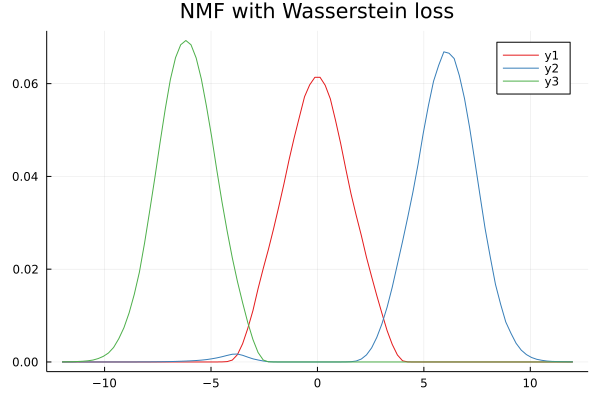

In [16]:
plot(coord, D; title="NMF with Wasserstein loss", palette=:Set1_3)

## Example: image data (MNIST)
Here we will download MNIST dataset using MLDatasets.jl and downscale each image to 14x14 to allow for faster runtime (since we are running on CPU).

In [17]:
sizex, sizey = 28, 28
factor = 2 # downscale factor
Σ = hcat([sum(I(sizex)[:, i:(i + factor - 1)]; dims=2) for i in 1:factor:sizex]...)
sizex, sizey = sizex ÷ factor, sizey ÷ factor
N = 256
x, y = MLDatasets.MNIST.traindata(Float64, sample(1:60_000, N; replace=false))
x = permutedims(x, (2, 1, 3))
x = cat([Σ' * x[:, :, i] * Σ for i in 1:N]...; dims=3)
X = simplex_norm!(reshape(x, (sizex * sizey, :)));

The columns of `X` now correspond to images "flattened" as vectors. We can preview a few images.

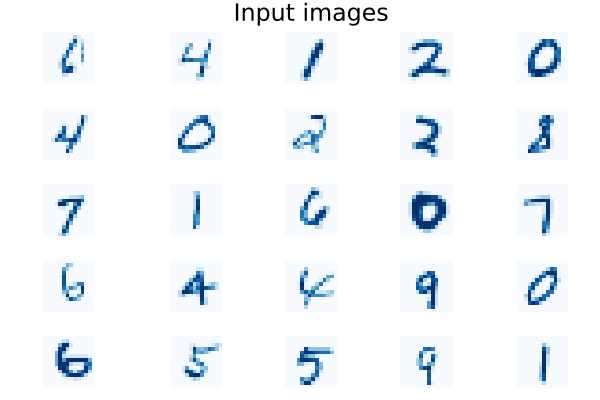

In [18]:
M = 25
plot(
    [
        heatmap(
            reshape(X[:, i], sizex, sizey);
            legend=:none,
            axis=nothing,
            showaxis=false,
            aspect_ratio=:equal,
            c=:Blues,
            yflip=true,
        ) for i in 1:M
    ]...;
    layout=(5, M ÷ 5),
    plot_title="Input images",
)

Now we can set up `coord`, cost matrix `C`, and specify parameters.

In [19]:
coord = reshape(collect(product(1:sizex, 1:sizey)), :)
C = pairwise(SqEuclidean(), coord)
C = C / mean(C);
ε = 0.0025
ρ1, ρ2 = (5e-3, 5e-3);

We compute the Gibbs kernel from `C`:

In [20]:
K = exp.(-C / ε);

Let us aim to learn `k = 25` atoms.

In [21]:
k = 25;

Initialise again randomly

In [22]:
D = rand(size(X, 1), k) # dictionary
simplex_norm!(D; dims=1) # norm columnwise
Λ = rand(k, size(X, 2)) # weights
simplex_norm!(Λ; dims=1); # norm rowwise

We now run 15 iterations of Wasserstein-NMF.

In [23]:
n_iter = 15
for iter in 1:n_iter
    @info "Wasserstein-NMF: iteration $iter"
    D .= solve_dict(
        X,
        K,
        ε,
        Λ,
        ρ2;
        alg=LBFGS(),
        options=Optim.Options(;
            iterations=250, g_tol=1e-4, show_trace=false, show_every=10
        ),
    )
    Λ .= solve_weights(
        X,
        K,
        ε,
        D,
        ρ1;
        alg=LBFGS(),
        options=Optim.Options(;
            iterations=250, g_tol=1e-4, show_trace=false, show_every=10
        ),
    )
end

[ Info: Wasserstein-NMF: iteration 1
[ Info: Wasserstein-NMF: iteration 2
[ Info: Wasserstein-NMF: iteration 3
[ Info: Wasserstein-NMF: iteration 4
[ Info: Wasserstein-NMF: iteration 5
[ Info: Wasserstein-NMF: iteration 6
[ Info: Wasserstein-NMF: iteration 7
[ Info: Wasserstein-NMF: iteration 8
[ Info: Wasserstein-NMF: iteration 9
[ Info: Wasserstein-NMF: iteration 10
[ Info: Wasserstein-NMF: iteration 11
[ Info: Wasserstein-NMF: iteration 12
[ Info: Wasserstein-NMF: iteration 13
[ Info: Wasserstein-NMF: iteration 14
[ Info: Wasserstein-NMF: iteration 15


We can inspect the atoms learned (columns of `D`):

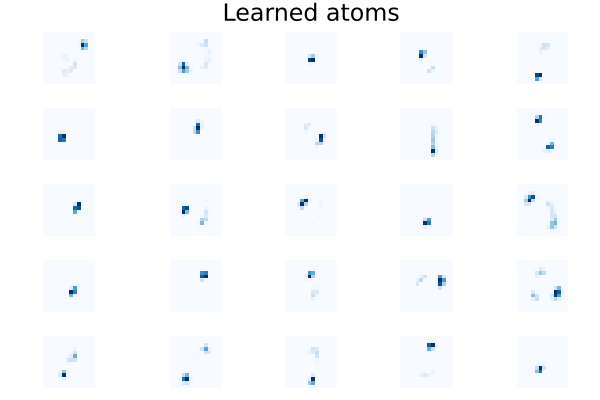

In [24]:
plot(
    [
        heatmap(
            reshape(D[:, i], sizex, sizey);
            legend=:none,
            axis=nothing,
            showaxis=false,
            aspect_ratio=:equal,
            c=:Blues,
            yflip=true,
        ) for i in 1:k
    ]...;
    layout=(5, k ÷ 5),
    plot_title="Learned atoms",
)

Finally, we can look at the images constructed by the low-rank approximation `DΛ` and compare to the original images that we previewed earlier.

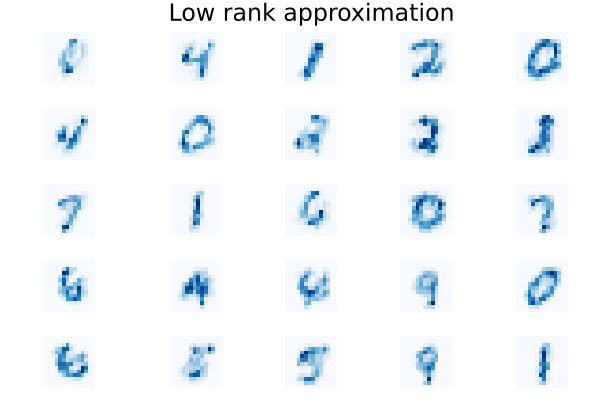

In [25]:
X_hat = D * Λ
plot(
    [
        heatmap(
            reshape(X_hat[:, i], sizex, sizey);
            legend=:none,
            axis=nothing,
            showaxis=false,
            aspect_ratio=:equal,
            c=:Blues,
            yflip=true,
        ) for i in 1:M
    ]...;
    layout=(5, M ÷ 5),
    plot_title="Low rank approximation",
)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*